In [129]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from models.BRUTAL_radially_constrained_cluster import *  # Adjust import as per your package structure
from models.radially_constrained_cluster import *
from models.X_RCC import XRCC
from visualization.custom_plots import standard_format, day_of_year_to_date

In [130]:
n_seas = 2
iters = 100

In [131]:
dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load().sel(lat=35, lon=70, method='nearest')
dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load().sel(lat=35, lon=70, method='nearest')
dataset_u100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load().sel(lat=35, lon=70, method='nearest')
dataset_v100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load().sel(lat=35, lon=70, method='nearest')

dataset_tp['time'] = dataset_t2m['time']
dataset_u100['time'] = dataset_t2m['time']
dataset_v100['time'] = dataset_t2m['time']

datasets = [dataset_tp, dataset_t2m, dataset_u100, dataset_v100]  # Add as many datasets as needed

In [132]:
datasets_tab = [dataset.to_dataframe() for dataset in datasets]

datasets_tab = [dataset.dropna() for dataset in datasets_tab]
datasets_tab = pd.concat(datasets_tab, axis=1)

datasets_tab = datasets_tab.drop(columns=['lon','lat','spatial_ref'])
# Remove hours from datetime
datasets_tab.index = pd.to_datetime(datasets_tab.index.astype(str))

In [133]:
# Reshape the table to keep the day of the year as the index and for the columns the values of the different variables at each year.
# The final shape will be 365 * n_years x n_variables. Remove the empy values
datasets_tab_res = datasets_tab.pivot_table(index=datasets_tab.index.dayofyear, columns=datasets_tab.index.year)
datasets_tab_res.columns = [f'{var}_{year}' for var, year in datasets_tab_res.columns]
datasets_tab_res

,2t_1969,2t_1970,2t_1971,2t_1972,2t_1973,2t_1974,2t_1975,2t_1976,2t_1977,2t_1978,...,v100_2009,v100_2010,v100_2011,v100_2012,v100_2013,v100_2014,v100_2015,v100_2016,v100_2017,v100_2018
time,,,,,,,,,,,,,,,,,,,,,
1,258.258759,266.536011,265.090790,261.394165,260.841614,263.315399,263.456512,264.614685,263.928070,261.357300,...,-1.896897,-1.657736,-1.698870,-1.139940,-2.191616,-1.945575,-1.989125,-1.721166,-1.877106,-2.030944
2,258.258759,266.163544,265.357300,261.355499,260.799713,263.647461,263.210510,264.250519,264.101898,261.096832,...,-1.907593,-1.725773,-1.730621,-1.169351,-2.184723,-1.888438,-1.929354,-1.784005,-1.902347,-2.073776
3,258.334442,265.819427,265.637787,261.193054,260.708466,263.982758,262.767487,264.163452,264.390320,261.193970,...,-1.861548,-1.737747,-1.750566,-1.196511,-2.213065,-2.006877,-1.748548,-1.752184,-1.980318,-2.142030
4,258.460419,265.460846,265.943451,261.213959,260.938660,264.038757,262.311951,263.966278,264.522461,261.357330,...,-1.889813,-1.764763,-1.745559,-1.351502,-2.273847,-2.119742,-1.661985,-1.722749,-2.162697,-1.969414
5,258.722351,265.060120,266.048035,261.265167,261.316254,264.067780,261.689026,263.931030,264.325256,261.965302,...,-1.901129,-1.771198,-1.722000,-1.461710,-2.229686,-2.210178,-1.601633,-1.682782,-2.179111,-1.819731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,268.919464,262.536591,262.683167,260.746613,262.874756,263.028748,265.796265,264.094788,262.722687,264.342621,...,-1.884226,-2.121694,-1.120774,-2.241248,-1.891780,-1.671768,-1.799474,-1.968760,-2.275977,-1.859400
363,268.214935,263.355103,261.793304,260.542206,262.798523,263.100952,265.398834,264.437317,262.606415,264.773987,...,-1.941701,-1.954360,-1.104157,-2.150667,-1.948658,-1.725152,-1.859532,-1.897155,-2.148521,-1.870161
364,267.534088,264.139771,261.271240,260.725769,262.972198,263.426941,265.101471,264.420074,262.324432,265.260834,...,-1.882675,-1.675607,-1.116212,-2.103099,-2.008337,-1.943787,-1.826624,-1.915457,-2.107237,-1.981569


In [134]:
dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.min(axis=0))/(datasets_tab_res.max(axis=0) - datasets_tab_res.min(axis=0))
#dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.mean(axis=0))/datasets_tab_res.std(axis=0)
dataset_tab_res_norm

,2t_1969,2t_1970,2t_1971,2t_1972,2t_1973,2t_1974,2t_1975,2t_1976,2t_1977,2t_1978,...,v100_2009,v100_2010,v100_2011,v100_2012,v100_2013,v100_2014,v100_2015,v100_2016,v100_2017,v100_2018
time,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.163027,0.163792,0.071620,0.004204,0.095568,0.094151,0.045359,0.069186,0.008152,...,0.178439,0.194268,0.224090,0.322357,0.107069,0.113213,0.131472,0.177337,0.168794,0.029864
2,0.000000,0.151107,0.171939,0.070419,0.002881,0.105896,0.086214,0.033228,0.074907,0.000000,...,0.175652,0.174420,0.216703,0.315045,0.108760,0.127966,0.148354,0.161494,0.162791,0.018349
3,0.002197,0.140094,0.180513,0.065377,0.000000,0.116325,0.071921,0.030328,0.084400,0.003040,...,0.187648,0.170927,0.212063,0.308293,0.101807,0.097385,0.199421,0.169516,0.144251,0.000000
4,0.005853,0.128618,0.189857,0.066026,0.007269,0.118066,0.057224,0.023759,0.088750,0.008153,...,0.180284,0.163046,0.213227,0.269760,0.086895,0.068243,0.223870,0.176938,0.100883,0.046405
5,0.013455,0.115793,0.193053,0.067616,0.019191,0.118969,0.037127,0.022585,0.082259,0.027181,...,0.177336,0.161168,0.218709,0.242360,0.097729,0.044893,0.240915,0.187014,0.096979,0.086645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,0.309410,0.035031,0.090195,0.051520,0.068402,0.086653,0.169637,0.028040,0.029511,0.101586,...,0.181740,0.058921,0.358590,0.048554,0.180628,0.183910,0.185037,0.114914,0.073946,0.075981
363,0.288962,0.061226,0.062994,0.045176,0.065995,0.088898,0.156815,0.039451,0.025684,0.115086,...,0.166766,0.107736,0.362456,0.071074,0.166674,0.170126,0.168075,0.132967,0.104254,0.073088
364,0.269201,0.086338,0.047035,0.050873,0.071479,0.099037,0.147221,0.038876,0.016403,0.130323,...,0.182144,0.189054,0.359651,0.082900,0.152033,0.113675,0.177369,0.128352,0.114070,0.043138


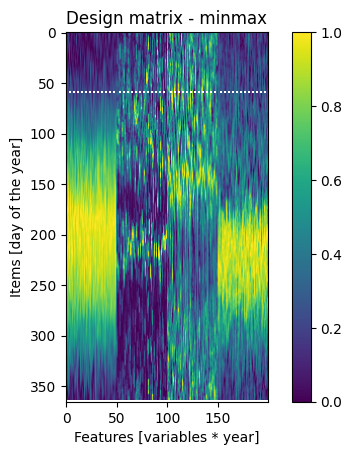

In [135]:
plt.figure()
plt.imshow(dataset_tab_res_norm.values)
plt.xlabel('Features [variables * year]')
plt.ylabel('Items [day of the year]')
plt.title('Design matrix - minmax')
plt.colorbar()

In [136]:
arrays = []

for grid_points_var in datasets:
    grid_points_var = np.asarray(grid_points_var)
    grid_points_var = np.reshape(grid_points_var, (365, int(grid_points_var.size/365)), order='F')
    
    if np.isnan(grid_points_var).any():
        array_tot = (np.full(n_seas, np.nan), np.full(iters, np.nan), np.full(iters, np.nan))
    
    arrays.append(grid_points_var)

combined_mask = ~np.any([np.all(np.isnan(arr), axis=0) for arr in arrays], axis=0)

normalized_arrays = []
for arr in arrays:
    array_tot = arr[:, combined_mask]
    array_tot = (array_tot - array_tot.min(axis=0)) / (array_tot.max(axis=0) - array_tot.min(axis=0))
    #array_tot = (array_tot - array_tot.mean(axis=0)) / array_tot.std(axis=0)
    normalized_arrays.append(array_tot)

    array_tot = np.concatenate(normalized_arrays, axis=1)

In [137]:
n_days = list(np.arange(0,365,5))

best, err, bp_list = single_fit_optimized(array_tot, n_seas, n_days, metric='euclidean')

2628it [00:03, 812.89it/s]


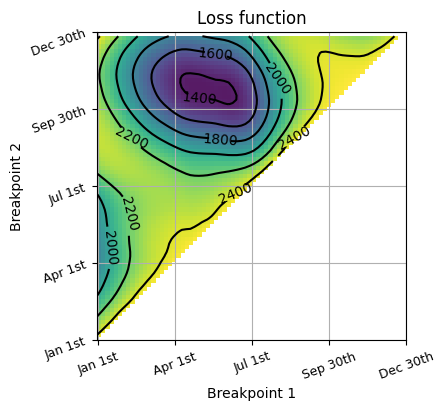

In [138]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

        

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='viridis', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

In [139]:
# generate random number between 0 and 365
list(np.sort(np.random.randint(0, 365, 2)))

[115, 243]

Text(0, 0.5, 'WCSS')

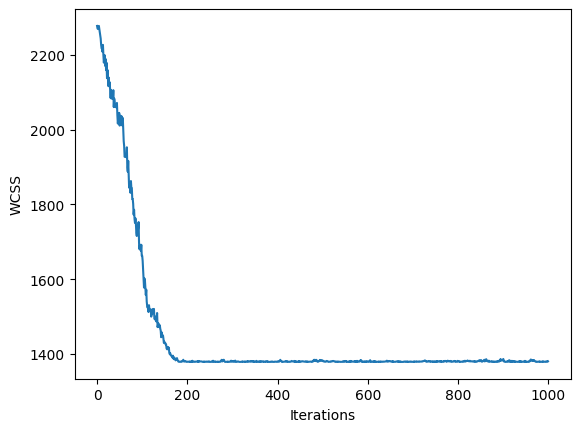

In [140]:
clustering_params = {
        'n_iter': 1000,
        'n_seas': 2,
        'learning_rate': 2,
        'scheduling_factor':1,
        'min_len': 1,
        'mode': 'single',
        'starting_bp': list(np.sort(np.random.randint(0, 365, 2))),
        'metric': 'euclidean',
    }

model = Radially_Constrained_Cluster(array_tot, **clustering_params)

model.fit()

plt.plot(model.error_history)
plt.xlabel('Iterations')
plt.ylabel('WCSS')

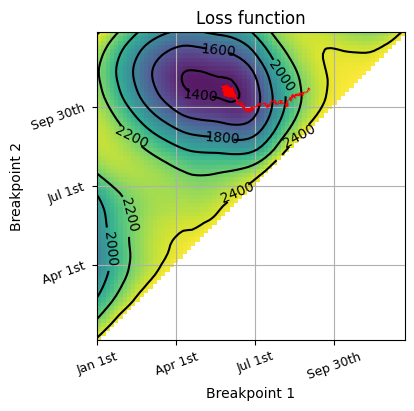

In [141]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='viridis', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

plt.plot(model.breakpoint_history[:,0],model.breakpoint_history[:,1], '-o', color='red', lw=0.5, markersize=0.1)

In [142]:
# x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
# y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# # Creare una meshgrid di x e y
# X, Y = np.meshgrid(np.unique(x), np.unique(y))

# # Creare un array per Z con le dimensioni di X e Y
# Z = np.empty(X.shape)

# # Riempire Z con valori medi di z_all raggruppati
# for i in range(len(np.unique(x))):
#     for j in range(len(np.unique(y))):
#         # Trovare i punti che corrispondono a questo (x, y)
#         indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
#         Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

# Z = np.where(np.isnan(Z), Z.T, Z)

# # Creare il grafico a contorni riempiti
# plt.figure(figsize=(8, 4))
# contour= plt.contour(X, Y, Z, levels=6, colors='black')
# plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='viridis', alpha=0.9)


# ax = plt.gca()
# ax.clabel(contour, inline=True, fontsize=10)

# #plt.colorbar(contour)
# plt.title('Loss function')
# plt.xlabel('Breakpoint 1')
# plt.ylabel('Breakpoint 2')
# plt.grid()

# # .
# ax = plt.gca()
# ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
# ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

# for j in range(100):
    
#     clustering_params = {
#         'n_iter': 200,
#         'n_seas': 2,
#         'learning_rate': 5,
#         'scheduling_factor' : 1,
#         'min_len': 1,
#         'mode': 'single',
#         'starting_bp': list(np.sort(np.random.randint(30, 335, 2))),
#         'metric': 'euclidean',
#     }
#     model = Radially_Constrained_Cluster(array_tot, **clustering_params)

#     model.fit()
#     #plt.plot(model.breakpoint_history[:,0],model.breakpoint_history[:,1], '-o', color='red', lw=0.05, markersize=0.05)
#     plt.scatter(model.breakpoint_history[-1,0],model.breakpoint_history[-1,1], color='red', s=1)